## Download testing data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import driveanon

In [3]:
# %%capture
# driveanon.save('13agtkTBW9HydkjwnquIt6axiDvbg1D9p', filename='data.tar.gz')
# ! tar -xzvf data.tar.gz
# ! rm data.tar.gz

## Plot difference maps

In [4]:
import glacierpoly as gpoly
import glob
import geopandas as gpd
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.io import imshow
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

import warnings
warnings.filterwarnings('ignore')

In [5]:
diffs = sorted(glob.glob('data/diff*.tif'))
gdf = gpd.read_file('data/south_cascade_rgi_polygon.geojson')

In [6]:
len(diffs)

17

In [7]:
dod = diffs[0]
dod

'data/diff_dem_ref_1970-09-29.tif'

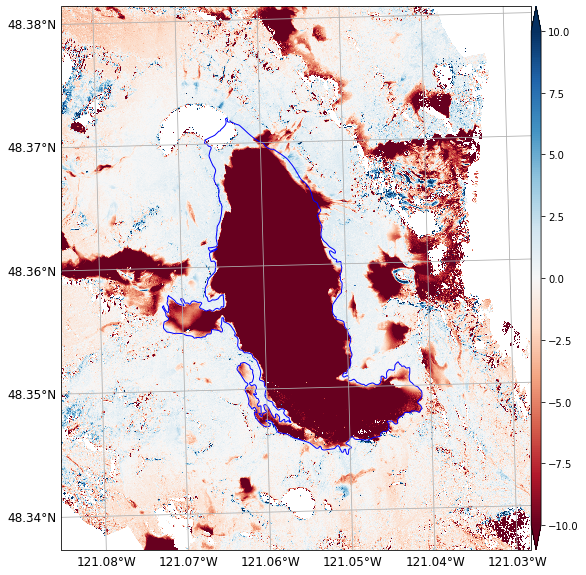

In [8]:
gpoly.plotting.plot_tif(dod, 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')

## Detect edges

In [9]:
def multi_dil(im, num, window):
    for i in range(num):
        im = dilation(im, window)
    return im
def multi_ero(im, num, window):
    for i in range(num):
        im = erosion(im, window)
    return im

def replace_and_fill_nodata_value(array, nodata_value, fill_value):
    if np.isnan(nodata_value):
        masked_array = np.nan_to_num(array, nan=fill_value)
    else:
        mask = array == nodata_value
        masked_array = np.ma.masked_array(array, mask=mask)
        masked_array = np.ma.filled(masked_array, fill_value=fill_value)

    return masked_array

In [10]:
source = rasterio.open(dod,masked=True)
array = source.read(1)
array = replace_and_fill_nodata_value(array, source.nodata, 0)

# array = cv2.bilateralFilter(array,21,75,75)
# array = cv2.GaussianBlur(array, (21,21), 10)

mask = array > -2
array = np.ma.masked_array(array, mask=mask)
array = np.ma.filled(array, fill_value=0)

array = np.uint8(array)

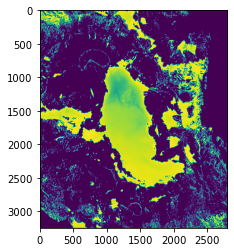

In [11]:
plt.imshow(array)

## erode islands

In [12]:
window = np.ones((9,9)).astype(int)
array = opening(array, window)

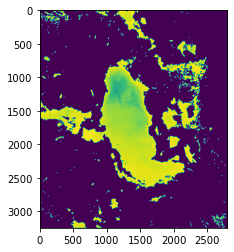

In [13]:
plt.imshow(array)

## detect edges

In [14]:
canny = cv2.Canny(array,50,150)

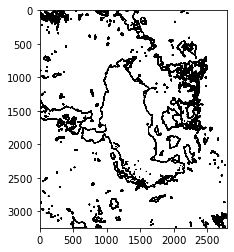

In [15]:
plt.imshow(canny,cmap='Greys',vmax=1);

## dilate edges

In [16]:
window = np.ones((7,7)).astype(int)
multi_dilated = multi_dil(canny, 4,window)

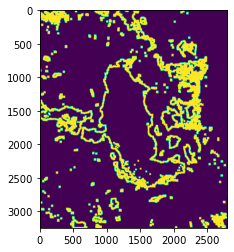

In [17]:
plt.imshow(multi_dilated)

## close areas

In [18]:
area_closed = area_closing(multi_dilated, 1000000)

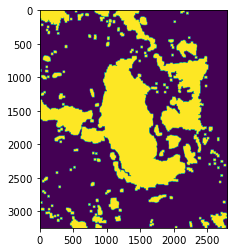

In [19]:
plt.imshow(area_closed)

## label areas

In [20]:
label_im = label(area_closed)
regions = regionprops(label_im)

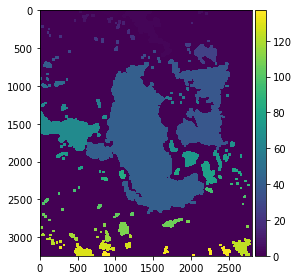

In [21]:
imshow(label_im,cmap=plt.cm.get_cmap('viridis', len(regions)))

## get stats

In [22]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation']
df = pd.DataFrame(regionprops_table(label_im, array, 
             properties=properties))

In [23]:
df.sort_values(by=['area'], ascending=False).head()

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation
40,1351249,1931507,3144085,0.429775,198.113079,0.699583,0.878680,0.350092
36,473397,858953,990069,0.478145,133.322577,0.551133,0.845795,-0.030258
64,208963,281732,426393,0.490071,177.400904,0.741708,0.889200,1.353781
2,128361,208721,402969,0.318538,157.296321,0.614988,0.938138,0.736358
0,78040,99803,134466,0.580370,79.042145,0.781940,0.832261,1.454063


## get largest region

In [24]:
max_area_index = df[df['area'] == df['area'].max()].index[0]
if max_area_index == 0:
    pass
else:
    max_area_index = max_area_index + 1

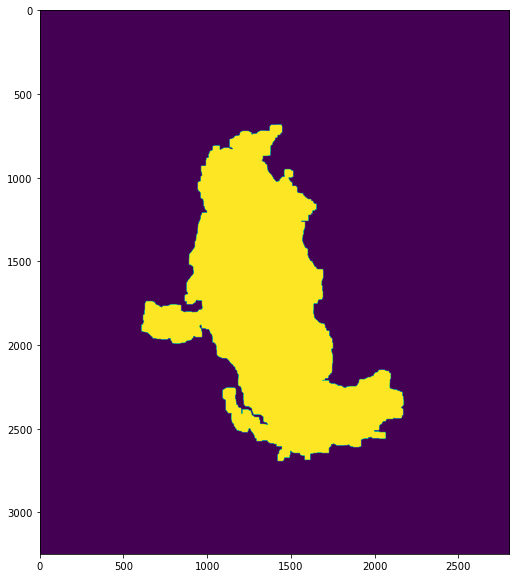

In [25]:
mask = label_im != max_area_index
masked_array = np.ma.masked_array(label_im, mask=mask)
masked_array = np.ma.filled(masked_array, fill_value=1)
masked_array = masked_array.astype(np.uint8)
fig,ax=plt.subplots(figsize=(10,10))
ax.imshow(masked_array)

## write to geotiff

In [26]:
! rm tmp.tif
! rm tmp.geojson

In [27]:
with rasterio.open(
    'tmp.tif',
    'w',
    driver='GTiff',
    height=masked_array.shape[0],
    width=masked_array.shape[1],
    count=1,
    dtype=masked_array.dtype,
    crs=source.crs,
    transform=source.transform,
) as dst:
    dst.write(masked_array, 1)

In [28]:
! gdal_polygonize.py tmp.tif tmp.geojson

Several drivers matching geojson extension. Using GeoJSON
Creating output tmp.geojson of format GeoJSON.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [29]:
diffs = sorted(glob.glob('data/diff*.tif'))
gdf = gpd.read_file('data/south_cascade_rgi_polygon.geojson')
gdf_new = gpd.read_file('tmp.geojson')
gdf_new = gdf_new[gdf_new.intersects(gdf.geometry[0])]
gdf_new = gdf_new[gdf_new.area == gdf_new.area.max()]

'data/diff_dem_ref_1970-09-29.tif'

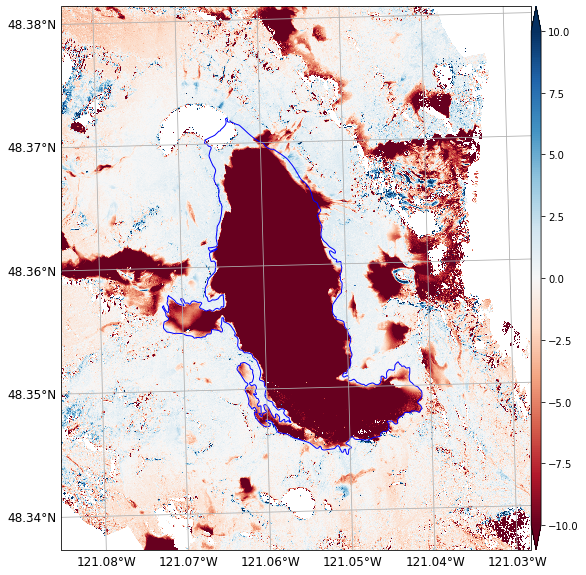

In [30]:
gpoly.plotting.plot_tif(diffs[0], 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
diffs[0]

'data/diff_dem_ref_1970-09-29.tif'

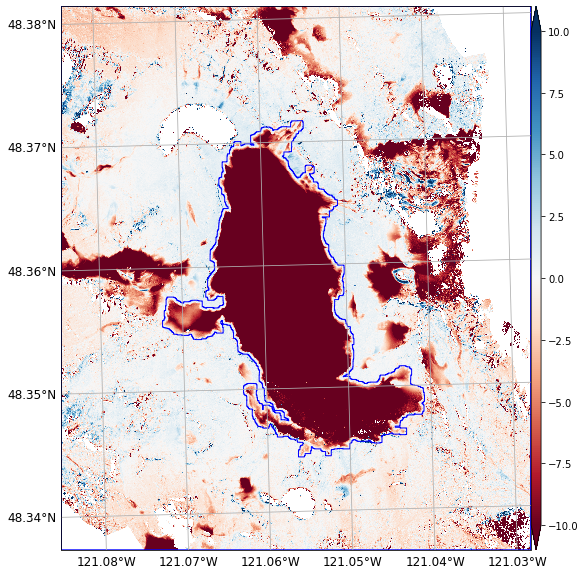

In [31]:
gpoly.plotting.plot_tif(dod, 
                        glacier_outline_gdf=gdf_new, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
dod